# Data Scientist Professional Case Study

### Company Background

Inn the Neighborhood is an online platform that allows people to rent out their properties for short stays. At the moment, only 2% of people who come to the site interested in renting out their homes start to use it.

The product manager would like to increase this. They want to develop an application to help people estimate how much they could earn renting out their living space. They hope that this would make people more likely to sign up.



### Customer Question

The product manager would like to know:
- Can you develop a way to predict how much someone could earn from renting their property that could power the application?




### Success Criteria

They want to avoid estimating prices that are more than 25 dollars off of the actual price, as this may discourage people.


### Dataset

The data you will use for this analysis can be accessed here: `"data/rentals.csv"`

## Data Validation

To begin, let's take a look at the data we have by importing it into a Pandas DataFrame. 

In [189]:
#Import pandas
import pandas as pd
import numpy as np

#Import dataset
rentals = pd.read_csv("data/rentals.csv")
rentals

,id,latitude,longitude,property_type,room_type,bathrooms,bedrooms,minimum_nights,price
0,958,37.76931,-122.43386,Apartment,Entire home/apt,1.0,1.0,1,$170.00
1,3850,37.75402,-122.45805,House,Private room,1.0,1.0,1,$99.00
2,5858,37.74511,-122.42102,Apartment,Entire home/apt,1.0,2.0,30,$235.00
3,7918,37.76669,-122.45250,Apartment,Private room,4.0,1.0,32,$65.00
4,8142,37.76487,-122.45183,Apartment,Private room,4.0,1.0,32,$65.00
...,...,...,...,...,...,...,...,...,...
8106,39342094,37.74010,-122.41196,House,Private room,2.0,3.0,30,$699.00
8107,39343373,37.77799,-122.42159,Condominium,Entire home/apt,1.0,1.0,1,$200.00
8108,39344101,37.73410,-122.38917,Hut,Private room,2.0,1.0,30,$69.00
8109,39350028,37.78144,-122.41207,Apartment,Entire home/apt,1.0,1.0,30,$187.00


#### Missing Values
Let's start by checking each column's dtype and checking for missing values.

In [190]:
display(rentals.info())
rentals.isna().sum()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8111 entries, 0 to 8110
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              8111 non-null   int64  
 1   latitude        8111 non-null   float64
 2   longitude       8111 non-null   float64
 3   property_type   8111 non-null   object 
 4   room_type       8111 non-null   object 
 5   bathrooms       8099 non-null   float64
 6   bedrooms        8107 non-null   float64
 7   minimum_nights  8111 non-null   int64  
 8   price           8111 non-null   object 
dtypes: float64(4), int64(2), object(3)
memory usage: 570.4+ KB


None

id                 0
latitude           0
longitude          0
property_type      0
room_type          0
bathrooms         12
bedrooms           4
minimum_nights     0
price              0
dtype: int64

#### Fixing data types and null values
Now we will assign some correct dtypes (property type, room type -> Category ; price -> float) and delete the rows with missing values. We can also drop the null values

In [191]:
#Set categories
rentals["property_type"] = rentals["property_type"].astype("category")
rentals["room_type"] = rentals["room_type"].astype("category")
#Clean price column
rentals["price"] = rentals["price"].str.replace("$", "")
rentals["price"] = rentals["price"].str.replace(",", "")
rentals["price"] = rentals["price"].astype("float")
#Delete rows with Null values
rentals = rentals.dropna()


#### Outlying values

When we check the values for bathrooms, we see that some properties have 10 bathrooms but only 1 bedroom. This makes sense because these properties are Bed and Breakfasts with shared rooms. The problem is that this will interfere with other property types and their prices when time comes to make the model. Because of this, I will remove them. 

I will remove properties with a minimum nights stay of more than 90, because then it would not be a short stay.  I will also remove the top 1% results to remove extreme outliers.




In [192]:
rentals = rentals[rentals["bathrooms"] < 10]
rentals = rentals[rentals["minimum_nights"] < 91]
rentals = rentals[rentals["price"] < np.quantile(rentals["price"], 0.99)]
rentals

,id,latitude,longitude,property_type,room_type,bathrooms,bedrooms,minimum_nights,price
0,958,37.76931,-122.43386,Apartment,Entire home/apt,1.0,1.0,1,170.0
1,3850,37.75402,-122.45805,House,Private room,1.0,1.0,1,99.0
2,5858,37.74511,-122.42102,Apartment,Entire home/apt,1.0,2.0,30,235.0
3,7918,37.76669,-122.45250,Apartment,Private room,4.0,1.0,32,65.0
4,8142,37.76487,-122.45183,Apartment,Private room,4.0,1.0,32,65.0
...,...,...,...,...,...,...,...,...,...
8106,39342094,37.74010,-122.41196,House,Private room,2.0,3.0,30,699.0
8107,39343373,37.77799,-122.42159,Condominium,Entire home/apt,1.0,1.0,1,200.0
8108,39344101,37.73410,-122.38917,Hut,Private room,2.0,1.0,30,69.0
8109,39350028,37.78144,-122.41207,Apartment,Entire home/apt,1.0,1.0,30,187.0


#### Combining low count property_types
There are 26 different property types, yet more than half of them have a really low percentage of values. I will combine these property types that represent less than 10% of the total values into a single "Other" category. 

In [193]:
series = rentals["property_type"].value_counts()

In [194]:
mask = (series/series.sum() * 100).lt(1)
rentals['property_type'] = np.where(rentals['property_type'].isin(series[mask].index),'Other',rentals['property_type'])

In [195]:
rentals

,id,latitude,longitude,property_type,room_type,bathrooms,bedrooms,minimum_nights,price
0,958,37.76931,-122.43386,Apartment,Entire home/apt,1.0,1.0,1,170.0
1,3850,37.75402,-122.45805,House,Private room,1.0,1.0,1,99.0
2,5858,37.74511,-122.42102,Apartment,Entire home/apt,1.0,2.0,30,235.0
3,7918,37.76669,-122.45250,Apartment,Private room,4.0,1.0,32,65.0
4,8142,37.76487,-122.45183,Apartment,Private room,4.0,1.0,32,65.0
...,...,...,...,...,...,...,...,...,...
8106,39342094,37.74010,-122.41196,House,Private room,2.0,3.0,30,699.0
8107,39343373,37.77799,-122.42159,Condominium,Entire home/apt,1.0,1.0,1,200.0
8108,39344101,37.73410,-122.38917,Other,Private room,2.0,1.0,30,69.0
8109,39350028,37.78144,-122.41207,Apartment,Entire home/apt,1.0,1.0,30,187.0


Our data is now clean and ready to move on! 

## Exploratory Analysis

It is now time to look at our data. let's import the needed libraries and get ready to work

In [196]:
#Data viz
import matplotlib.pyplot as plt
import seaborn as sns



Lets start by seeing our count of each of the different categories

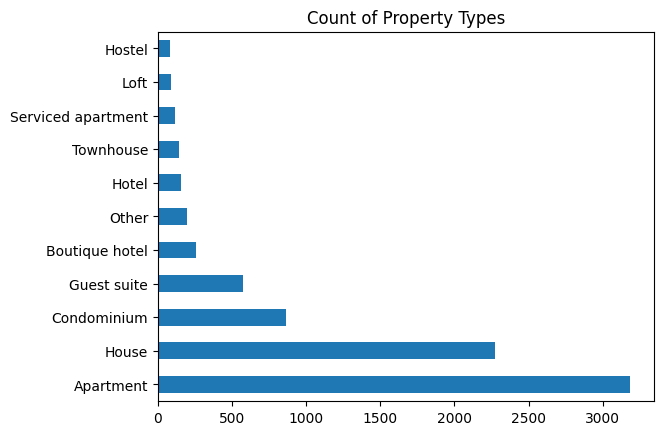

In [197]:
rentals["property_type"].value_counts().plot(kind="barh", title = "Count of Property Types")
plt.show()

<AxesSubplot:title={'center':'Count per Room Type'}>

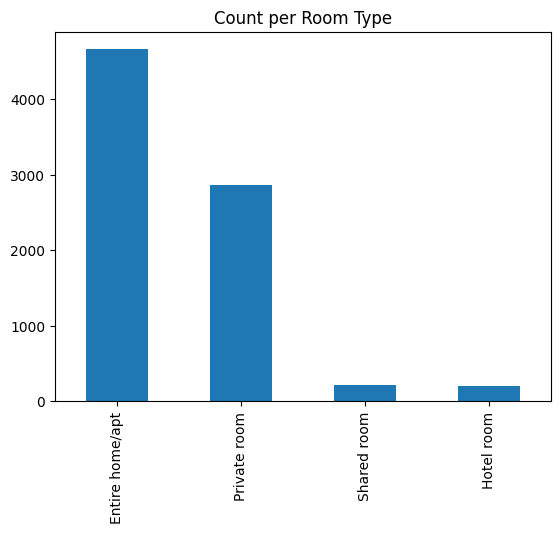

In [198]:
rentals["room_type"].value_counts().plot(kind = "bar", title = "Count per Room Type")

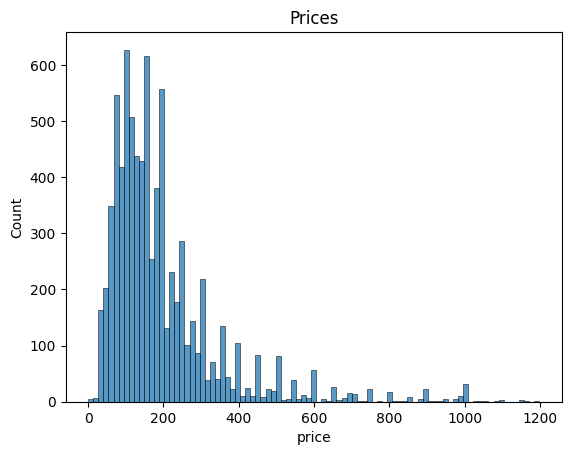

In [199]:
sns.histplot(x="price", data = rentals)
plt.title("Prices")
plt.show()

I wonder if there is a relationship between different property types and room types with price.

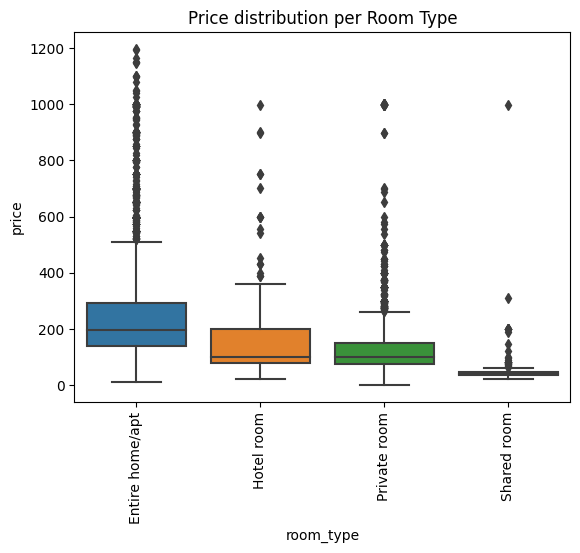

In [200]:
sns.boxplot(x="room_type", y="price", data = rentals)
plt.xticks(rotation = 90)
plt.title("Price distribution per Room Type")
plt.show()

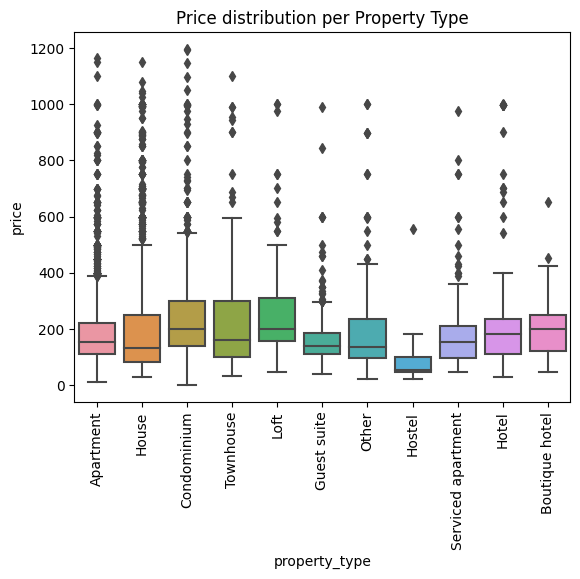

In [201]:
sns.boxplot(x="property_type", y="price", data = rentals)
plt.xticks(rotation = 90)
plt.title("Price distribution per Property Type")
plt.show()

We can see a relationship more clearly in the room types than the property types. There are still many outliers for each category.

Now lets look at our numerical response values

In [202]:
rentals.describe()

,id,latitude,longitude,bathrooms,bedrooms,minimum_nights,price
count,7.936000e+03,7936.000000,7936.000000,7936.000000,7936.000000,7936.000000,7936.000000
mean,2.028398e+07,37.765722,-122.430305,1.364352,1.328629,15.081527,196.348160
std,1.226009e+07,0.022898,0.027058,0.804855,0.890115,15.017437,155.806769
min,9.580000e+02,37.704630,-122.513060,0.000000,0.000000,1.000000,0.000000
25%,9.019020e+06,37.751230,-122.443000,1.000000,1.000000,2.000000,100.000000
50%,2.162208e+07,37.768710,-122.424865,1.000000,1.000000,4.000000,150.000000
75%,3.121223e+07,37.785263,-122.410667,1.500000,2.000000,30.000000,235.000000
max,3.935418e+07,37.828790,-122.368570,8.000000,6.000000,90.000000,1198.000000


Next, i will display both a seaborn pairplot and a correlation heatmap-matrix to find relationships between our variables.

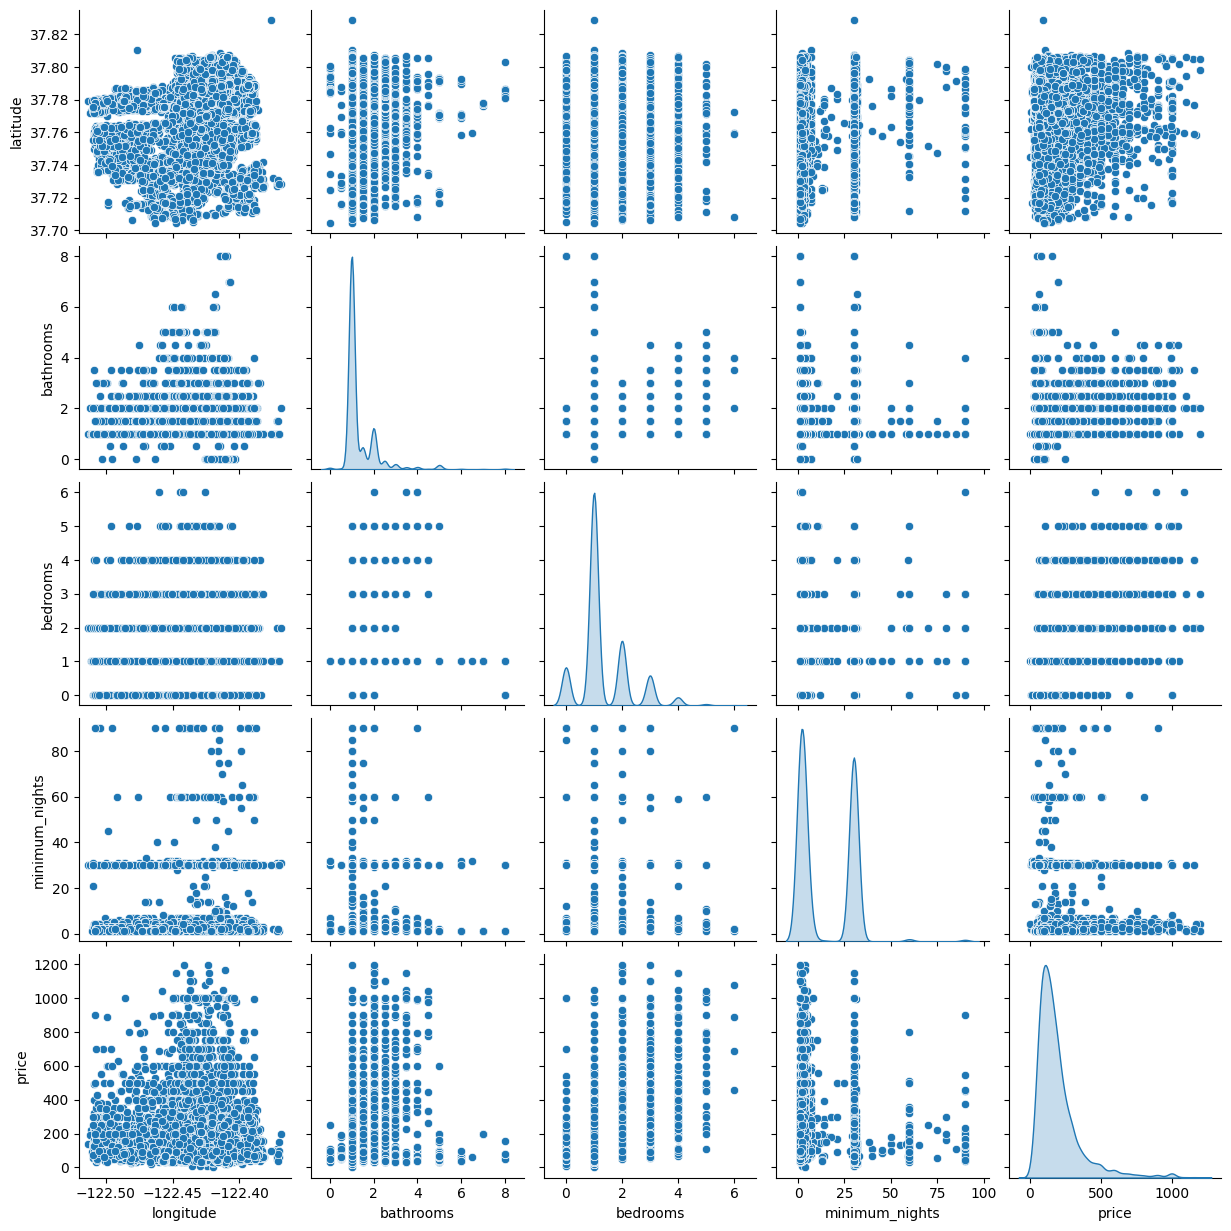

In [203]:
sns.pairplot(rentals, diag_kind="kde", x_vars=["longitude","bathrooms","bedrooms","minimum_nights", "price"], y_vars=["latitude","bathrooms","bedrooms","minimum_nights", "price"])

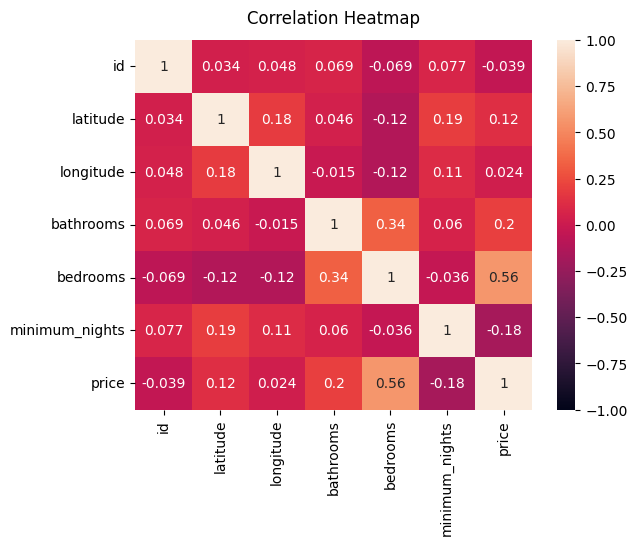

In [204]:
heatmap = sns.heatmap(rentals.corr(), vmin=-1, vmax=1, annot=True)
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

Theres seems to be small relations  between the amount of bedrooms and bathrooms in a property, and the amount of bedrooms and the final price. Let's see how this correlation looks like.

<AxesSubplot:xlabel='bathrooms', ylabel='bedrooms'>

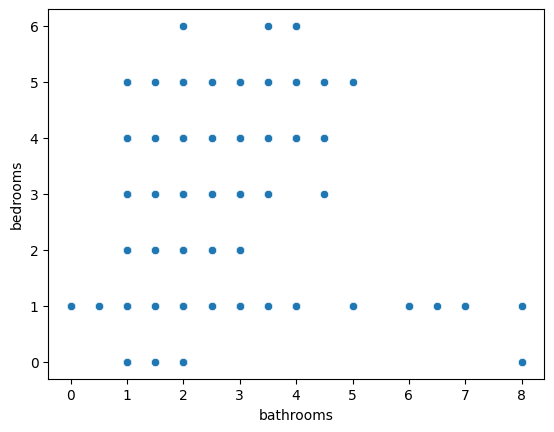

In [205]:
sns.scatterplot(x="bathrooms", y="bedrooms", data = rentals)

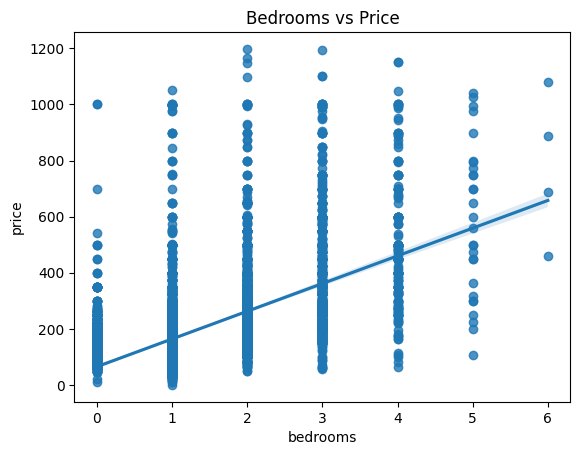

In [206]:
sns.regplot(x="bedrooms", y="price", data = rentals)
plt.title("Bedrooms vs Price")
plt.show()


## Model Development and Evaluation
To develop the model to be used we will show three different regression models. , evaluate them, measure the RMSE and R values, and select the best one to use as our final predictor and measure success to our initial business problem.

The models to use will be a Linear Regression, Stochastic Gradient Boosting, and Random Forest Regression. These models have been chosen since they are great ways to get regression and will be useful to find solutions and compare behaviours.

We will also use GridSearchCV to explore some parameters to try to find our optimal model.

In [207]:
#Importing all libraries
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error as MSE
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

rentals

,id,latitude,longitude,property_type,room_type,bathrooms,bedrooms,minimum_nights,price
0,958,37.76931,-122.43386,Apartment,Entire home/apt,1.0,1.0,1,170.0
1,3850,37.75402,-122.45805,House,Private room,1.0,1.0,1,99.0
2,5858,37.74511,-122.42102,Apartment,Entire home/apt,1.0,2.0,30,235.0
3,7918,37.76669,-122.45250,Apartment,Private room,4.0,1.0,32,65.0
4,8142,37.76487,-122.45183,Apartment,Private room,4.0,1.0,32,65.0
...,...,...,...,...,...,...,...,...,...
8106,39342094,37.74010,-122.41196,House,Private room,2.0,3.0,30,699.0
8107,39343373,37.77799,-122.42159,Condominium,Entire home/apt,1.0,1.0,1,200.0
8108,39344101,37.73410,-122.38917,Other,Private room,2.0,1.0,30,69.0
8109,39350028,37.78144,-122.41207,Apartment,Entire home/apt,1.0,1.0,30,187.0


The first thing to do is to encode our property type and room type categorical values

In [208]:
rentals = pd.get_dummies(rentals, columns = ["property_type", "room_type"])

We will use the same train data for all models, let's create them.

In [209]:
labels = rentals["price"]
datax = rentals.drop("price", axis = 1)
X_train, X_test, y_train, y_test = train_test_split(datax, labels, test_size = 0.25, random_state = 7)

Model development time!

In [210]:
lr = LinearRegression(fit_intercept = False)
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)
rmse_lr = MSE(y_test, y_pred_lr, squared = False)
r_sq_lr = lr.score(X_test, y_test)
print('RMSE of Linear Regression: {:.2f}'.format(rmse_lr)) 
print('R squared value of Linear Regression: {:.2f}'.format(r_sq_lr)) 

print(lr.coef_)

RMSE of Linear Regression: 121.05
R squared value of Linear Regression: 0.44
[ 1.66550679e-07  1.16756486e+03  3.39659958e+02  1.52814978e+01
  8.17859579e+01 -2.37660741e+00 -6.76810268e+02 -6.25280420e+02
 -6.56136576e+02 -6.96701045e+02 -7.46314272e+02 -5.72962797e+02
 -6.60551114e+02 -5.89726513e+02 -6.39427930e+02 -6.54721210e+02
 -6.35827506e+02 -1.70685351e+03 -1.79325578e+03 -1.79764460e+03
 -1.85670576e+03]


In [211]:
rf = RandomForestRegressor()
params_rf = {"n_estimators": [100,350,500],
             'max_features': ["log2","auto","sqrt"]
            }
grid_rf = GridSearchCV(estimator = rf, param_grid = params_rf, scoring = "neg_mean_squared_error", cv = 3, n_jobs =-1)
grid_rf.fit(X_train, y_train)
best_model_rf = grid_rf.best_estimator_
y_pred_rf = best_model_rf.predict(X_test)
rmse_rf = MSE(y_test, y_pred_rf, squared = False)
r_sq_rf = best_model_rf.score(X_test, y_test)
print('RMSE of best Random Forest model: {:.2f}'.format(rmse_rf)) 
print('R squared value of best Random Forest model: {:.2f}'.format(r_sq_rf)) 


RMSE of best Random Forest model: 105.10
R squared value of best Random Forest model: 0.58


In [212]:
grb = GradientBoostingRegressor()
params_grb = {"n_estimators": [100,350,500],
             'subsample': [0.75,0.85,0.95], 
              "max_features":[0.65,0.75,0.85]
            }
grid_grb = GridSearchCV(estimator = grb, param_grid = params_grb, scoring = "neg_mean_squared_error", cv = 3, n_jobs =-1)
grid_grb.fit(X_train, y_train)
best_model_grb = grid_grb.best_estimator_
y_pred_grb = best_model_grb.predict(X_test)
rmse_grb = MSE(y_test, y_pred_grb, squared = False)
r_sq_grb = best_model_grb.score(X_test, y_test)
print('RMSE of best Gradient Boosting model: {:.2f}'.format(rmse_grb)) 
print('R squared value of best Gradient Boosting model: {:.2f}'.format(r_sq_grb)) 

RMSE of best Gradient Boosting model: 105.03
R squared value of best Gradient Boosting model: 0.58


As we can see, both the Random Forest and the Gradient Booster show the lowest RMSE and the highest R squared values. This means that they have the less general error in it's prediction, and that the model is somewhat accurate. 

## Comparison to Business Success

We can clearly see how the best models are Random Forest and Gradient Boosting, based on RMSE and R^2 values. 

For each model to be considered a success, we need to make sure that each model is less than 25$ away from the actual price. The best way to do this is to find the average deviation from the real price. Let's make a new dataframe with all the predictions. 

Just for fun, i will add an Average column that will give me the average between all methods.

In [213]:
pred_array = pd.DataFrame(y_test)
pred_array["LinReg"] = y_pred_lr
pred_array["RanFor"] = y_pred_rf
pred_array["GradBoost"] = y_pred_grb
pred_array["Average"] = pred_array.loc[:,[c for c in pred_array.columns if c!= "price"]].mean(axis = 1)
pred_array

,price,LinReg,RanFor,GradBoost,Average
5088,200.0,176.459367,188.062,137.160078,167.227148
2238,165.0,155.874582,140.030,132.947903,142.950829
4569,110.0,93.233822,124.378,125.577829,114.396550
8104,113.0,209.324614,208.580,221.394406,213.099673
3356,120.0,66.216390,99.404,64.770550,76.796980
...,...,...,...,...,...
2531,150.0,360.755826,296.992,306.638750,321.462192
5222,245.0,271.095864,268.466,237.278037,258.946633
5680,200.0,242.673529,187.734,206.886055,212.431195
3791,65.0,69.099089,97.466,80.608742,82.391277


Next, let's find the Mean Average Deviation. I'll create a new column on the dataframe with the difference of each model and then get each column's mean.

In [214]:
pred_array["D_lr"] = pred_array["price"] - pred_array["LinReg"]
pred_array["D_rf"] = pred_array["price"] - pred_array["RanFor"]
pred_array["D_grb"] = pred_array["price"] - pred_array["GradBoost"]
pred_array["D_avg"] = pred_array["price"] - pred_array["Average"]
MAD_lr = pred_array["D_lr"].mean()
MAD_rf = pred_array["D_rf"].mean()
MAD_grb = pred_array["D_grb"].mean()
MAD_avg = pred_array["D_avg"].mean()
print("Linear Regression MAD:", MAD_lr)
print("Random Forest MAD:", MAD_rf)
print("Gradient Boosting MAD:", MAD_grb)
print("Average MAD:", MAD_avg)

Linear Regression MAD: 5.321727432868134
Random Forest MAD: 6.119068884408602
Gradient Boosting MAD: 7.419936641111514
Average MAD: 6.286910986129418


Even though the Mean Average Deviations look good, let's see what percentage of properties have been successfully predicted with under

In [215]:
pred_array

,price,LinReg,RanFor,GradBoost,Average,D_lr,D_rf,D_grb,D_avg
5088,200.0,176.459367,188.062,137.160078,167.227148,23.540633,11.938,62.839922,32.772852
2238,165.0,155.874582,140.030,132.947903,142.950829,9.125418,24.970,32.052097,22.049171
4569,110.0,93.233822,124.378,125.577829,114.396550,16.766178,-14.378,-15.577829,-4.396550
8104,113.0,209.324614,208.580,221.394406,213.099673,-96.324614,-95.580,-108.394406,-100.099673
3356,120.0,66.216390,99.404,64.770550,76.796980,53.783610,20.596,55.229450,43.203020
...,...,...,...,...,...,...,...,...,...
2531,150.0,360.755826,296.992,306.638750,321.462192,-210.755826,-146.992,-156.638750,-171.462192
5222,245.0,271.095864,268.466,237.278037,258.946633,-26.095864,-23.466,7.721963,-13.946633
5680,200.0,242.673529,187.734,206.886055,212.431195,-42.673529,12.266,-6.886055,-12.431195
3791,65.0,69.099089,97.466,80.608742,82.391277,-4.099089,-32.466,-15.608742,-17.391277


We can determine that all models have an acceptable average deviation, with the one with the lowest deviation being Linear Regression. This is contradicting what the RMSE and R^2 values had told us before. Because of this, I believe that the best model to use should be Random Forest Regression.

## Final Summary and Recommendations

In the end, we managed to develop several models that could answer our goal. Using the linear regression model should be able to estimate a close enough price for our customers. 

### Recommendations

* If we had more data, especially quantitative data, we could get an even more accurate model

* Because of how different each type of property or room behaves, it might be worth to look into making different prediction models for each type

* There are many many outliers in our data, which means that data is very varied, or there are some validation checks missing. Implementing these could make it so theres more organized data and better models.